# Propositional logic: Wumpus World

In [1]:
import itertools
from itertools import product
from tabulate import tabulate

In [2]:
def eval_sentence(sentence, model) -> bool:
    """Evaluate a sentence using the given model. The model is a dictionary that maps symbols to boolean values."""
    ret_val = eval(sentence, {}, model)
    assert isinstance(ret_val, bool)
    return eval(sentence, {}, model)


def evaluate_sentences(sentences, model):
    """Evaluate all the sentences using the given model. The model is a dictionary that maps symbols to boolean values."""
    model = model.copy()
    res = {}
    for sentence_name, sentence_expr in sentences.items():
        sentence_value = eval_sentence(sentence_expr, model)
        model[sentence_name] = sentence_value
        res[sentence_name] = sentence_value
    return res


def generate_all_models(symbols):
    """Generate all possible models for the given symbols. A model is a dictionary that maps symbols to boolean values."""
    for values in product([True, False], repeat=len(symbols)):
        yield dict(zip(symbols, values))


def table_model_checking(symbols, sentences):
    """Generate a table with all the possible models and the evaluation of the sentences.
    The last column is the evaluation of the Knowledge Base (KB).
    """
    table = [symbols + list(sentences.keys()) + ["KB"]]
    for model in generate_all_models(symbols):
        sentence_values = evaluate_sentences(sentences, model)
        sentence_values = list(sentence_values.values())
        kb = all(sentence_values)
        table.append([*model.values(), *sentence_values, kb])
    return table


def print_table_model_checking(symbols, sentences, only_true=False):
    """Print the table generated by table_model_checking. If only_true is True, only the models that satisfy all the sentences are printed."""
    table = table_model_checking(symbols, sentences)
    if only_true:
        table_content = [row for row in table[1:] if row[-1]]
    else:
        table_content = table[1:]
    print(tabulate(table_content, headers=table[0]))


def model_checking(symbols, sentences):
    """Returns a list of models that satisfy all the sentences"""
    res = []
    for model in generate_all_models(symbols):
        sentence_values = evaluate_sentences(sentences, model)
        kb = all(sentence_values.values())
        if kb:
            res.append(model)
    return res


def entails(symbols, sentences, sentences_to_check) -> bool:
    """Check if the sentences entail the given sentence. That is, if the sentences are true, then the given sentence is also true."""
    models_checked = [x for x in model_checking(symbols, sentences)]
    if len(models_checked) == 0:
        return False
    return all(
        eval_sentence(sentences_to_check, model)
        for model in models_checked
    )

## Wumpus World

Consider an instance of the *Wumpus world* ([AIMA](https://aima.cs.berkeley.edu/global-index.html)).
Here the world is a $3 \times 3$ grid, and the agent can perceive stenches in adjacent squares.
You don't need to consider pits at all in this problem.

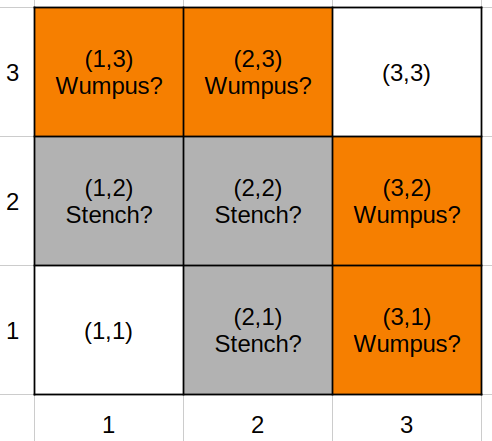

We are only interested in representing the presence of the Wumpus in some squares, i.e., $W_{1,3}$, $W_{2,3}$, $W_{3,2}$, $W_{3,1}$, and the perceived stench, i.e., $S_{1,2}$, $S_{2,2}$, $S_{2,1}$.

### Question
Write a set of sentences in propositional logic that represent the a-priori knowledge of the agent, i.e., the knowledge that the agent has before it starts to perceive the world.
Those sentences should express the facts that:
- a stench means that there is a Wumpus in an adjacent square,
- there is exactly one Wumpus in the considered squares (*hint: it can be expressed either with one long sentence or few shorter sentences*).

Use LaTeX math mode to write the sentences in the cell below.
Note that you can use the following operators: $\land$, $\lor$, $\lnot$, $\implies$, $\iff$.

**Answer.** The a-priori knowledge can be represented with the following propositional logic sentences:

- There is no stench in square $(1,1)$, and there is no Wumpus in square $(1,1)$:
$$\lnot S_{1,1} \land \lnot W_{1,1}$$

- The presence of a stench in a square implies that there is a Wumpus in an adjacent square (excluding diagonals):
$$S_{1,2} \implies (W_{1,3} \lor W_{2,2})$$
$$S_{2,2} \implies (W_{1,2} \lor W_{2,3} \lor W_{3,2} \lor W_{2,1})$$
$$S_{2,1} \implies (W_{2,2} \lor W_{3,1})$$

- There is exactly one Wumpus in the considered squares, which can be expressed as:
$$(W_{1,3} \land \lnot W_{2,3} \land \lnot W_{3,2} \land \lnot W_{3,1}) \lor (W_{2,3} \land \lnot W_{1,3} \land \lnot W_{3,2} \land \lnot W_{3,1}) \lor$$
$$(W_{3,2} \land \lnot W_{1,3} \land \lnot W_{2,3} \land \lnot W_{3,1}) \lor (W_{3,1} \land \lnot W_{1,3} \land \lnot W_{2,3} \land \lnot W_{3,2})$$

- Additional constraints based on the structure of the Wumpus world (a stench in one square prevents Wumpus in specific other squares):
$$S_{1,2} \implies \lnot (W_{2,3} \lor W_{3,2} \lor W_{3,1})$$
$$S_{2,2} \implies \lnot (W_{1,3} \lor W_{3,1})$$
$$S_{2,1} \implies \lnot (W_{1,3} \lor W_{2,3} \lor W_{3,2})$$

- It is not possible to have a stench in all squares that could possibly have a stench:
$$\lnot (S_{1,2} \land S_{2,2} \land S_{2,1})$$

In [3]:
symbols = ["S11", "S12", "S22", "S21", "W13", "W23", "W32", "W31", "W12", "W22", "W21", "W11"]
sentences = {
    'R1': 'not S11',                 
    'R2': 'not W11',                  
    'R3': 'S12 == (W11 or W13 or W22)',
    'R4': 'S22 == (W12 or W23 or W32 or W21)', # Stench in (2,2) implies Wumpus in adjacent cells
    'R5': 'S21 == (W11 or W22 or W31)', # Stench in (2,1) implies Wumpus in (2,2) or (3,1)
    
    'R6': '((W13 and not (W23 or W32 or W31)) or '    # Exactly one Wumpus in one of these four squares
           '(W23 and not (W13 or W32 or W31)) or '
           '(W32 and not (W13 or W23 or W31)) or '
           '(W31 and not (W13 or W23 or W32)))',
    
    'R7': 'S12 == (not (W23 or W32 or W31))',    # If stench in (1,2), Wumpus cannot be in other cells
    'R8': 'S22 == (not (W12 or W21))',           # If stench in (2,2), Wumpus cannot be in other cells
    'R9': 'S21 == (not (W13 or W23 or W32))',    # If stench in (2,1), Wumpus cannot be in other cells

    'R10': 'not (S12 and S22 and S21)'                #not possible to have stench in all stench cells
}

In [4]:
print_table_model_checking(symbols, sentences, only_true=True)

S11    S12    S22    S21    W13    W23    W32    W31    W12    W22    W21    W11    R1    R2    R3    R4    R5    R6    R7    R8    R9    R10    KB
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----  ----
False  False  True   False  False  True   False  False  False  False  False  False  True  True  True  True  True  True  True  True  True  True   True
False  False  True   False  False  False  True   False  False  False  False  False  True  True  True  True  True  True  True  True  True  True   True


### Question

Now, the agent starts to perceive the world.
Update the set of sentences to include the new knowledge that the agent acquires:
- the agent perceives no stench in square $(1,2)$,
- the agent perceives stench in square $(2,2)$.

Check if the agent can conclude that:

1. there is no Wumpus in square $(3,1)$
2. a stench cannot be perceived in square $(2,1)$.

In [5]:
sentences.update({
    'R11': 'not S12',                 
    'R12': 'S22',
})

In [6]:
entails_W31 = entails(symbols, sentences, 'not W31')
entails_S21 = entails(symbols, sentences, 'not S21')
(entails_W31, entails_S21)

(True, True)

## Three doors

Now forget about the Wumpus world and consider the following new problem.

You are in front of **three doors**. 
Behind one of them there is a treasure, behind the others there are monsters.

There is a sign on each door:
- **Door 1**: *"The treasure is behind one of the doors 1 or 3."*
- **Door 2**: *"The treasure is not behind this door."*
- **Door 3**: *"The treasure is behind one of the doors 1 or 2."*

Unfortunately, you don't know which sign is true and which is false, but you know that one is false and two are true.
You can open one single door: if you open the door with the treasure, you win, if you open a door with a monster, you lose (your life...).

Can you conclude which door to open?

- Write a set of sentences in propositional logic (in Python) that represent the a-priori knowledge of the agent, i.e., the knowledge that the agent has before it opens any door.
- Check if the agent can conclude which door to open.
- Explain your reasoning in English in a Markdown cell after the Python cells (before the cell containing the testing).

In [7]:
# You can use all the symbols that you want, but include T1, T2, and T3 for representing the treasure being behind door 1, 2, or 3, respectively.
symbols = ["T1", "T2", "T3", "S1", "S2", "S3"]

sentences = {
    'R1': '((T1 and not T2 and not T3) or (not T1 and T2 and not T3) or (not T1 and not T2 and T3))',
    'R2': '((S1 and S2 and not S3) or (S1 and not S2 and S3) or (not S1 and S2 and S3))',
    'R3': 'S1 == (T1 or T3)',
    'R4': 'S2 == (not T2)',
    'R5': 'S3 == (T1 or T2)'
}

**Answer.** The reasoning to solve this problem using propositional logic. We first define symbols for each possibility:

- Let $T_1$ represent "The treasure is behind door 1".
- Let $T_2$ represent "The treasure is behind door 2".
- Let $T_3$ represent "The treasure is behind door 3".
- Let $S_1$ represent "The sign on door 1 is true".
- Let $S_2$ represent "The sign on door 2 is true".
- Let $S_3$ represent "The sign on door 3 is true".

Given the problem statement, we have the following sentences:

R1. Exactly one door has the treasure:
$$
(T_1 \land \lnot T_2 \land \lnot T_3) \lor (\lnot T_1 \land T_2 \land \lnot T_3) \lor (\lnot T_1 \land \lnot T_2 \land T_3)
$$

R2. Exactly one sign is false and two are true:
$$
(S_1 \land S_2 \land \lnot S_3) \lor (S_1 \land \lnot S_2 \land S_3) \lor (\lnot S_1 \land S_2 \land S_3)
$$

R3. Sign on door 1 says the treasure is behind door 1 or 3:
$$
S_1 \implies (T_1 \lor T_3)
$$

R4. Sign on door 2 says the treasure is not behind door 2:
$$
S_2 \implies \lnot T_2
$$

R5. Sign on door 3 says the treasure is behind door 1 or 2:
$$
S_3 \implies (T_1 \lor T_2)
$$

The agent's task is to find out which $T_x$ is true.

In [8]:
satisfying_models = model_checking(symbols, sentences)
for t in ["T1", "T2", "T3"]:
    if entails(symbols, sentences, t):
        print(f"The treasure is behind door {t[1]}")

The treasure is behind door 3
